### PyTorch RNN Tutorial - Name Classification Using A Recurrent Neural Net

https://www.youtube.com/watch?v=WEV61GmmPrk&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=21

__Note__: 这个 Tutorial 不是直接用 PyTorch 的 RNN 包，而是我们自己 implement 一个 RNN 来用!


Project Process: 
1. preprocessing， 比如把有音标的单词给处理一下
2. how to encode data. category/country 直接用index, 然后产生 tensor array, ```torch.tensor([all_categories.index(category)], dtype=torch.long)```. 然后 name 的话，就得对每个字母 1 hot, 然后一个name 的length作为一个 dimension, 输出一个 matrix (tensor). 感觉这里好多都是用 ```tensor = torch.zeros(len(line), 1, N_LETTERS)```, 然后再一个个 assign 值，来产生 encoded data in tensor format
3. define model, 这个直接照图写
4. training loop, 知道名字怎么 sequence 产生一个 tensor 然后跟 category/country 的 tensor 一起， 传到 loss function， 然后其他的都是照常的 training loop 的写法

thoughts: 
- model 和 training loop 不难，主要是data 怎么预处理和 encoding 产生 input tensor 比较麻烦


In [1]:
import sys
import os

# This is a nice trick to add other python file to this notebook, 这样就挺方便的!!!
# 本质上就是告诉 python interpreter, 你也去看一下我给你添加的这个 file path， 然后正好是我要 import 的那个 path
# 但是这个方法好像有点小问题，就是你 import 的文件改了，你这个kernel 也得 refresh
# "sys.path contains a list of directories that the interpreter will search in for the required module"
#  credit: https://stackoverflow.com/questions/49264194/import-py-file-in-another-directory-in-jupyter-notebook  

# 这里好像非得 join ".." 才行
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/PyTorch_RNN/pytorch-examples/rnn-name-classification")



In [2]:
print(sys.path)

['/Users/qizhong/Downloads/PyTorch_Learning/PyTorch_RNN', '/python', '/python/build', '/Users/qizhong/Downloads/PyTorch_Learning/PyTorch_RNN', '/opt/anaconda3/envs/pytorch/lib/python37.zip', '/opt/anaconda3/envs/pytorch/lib/python3.7', '/opt/anaconda3/envs/pytorch/lib/python3.7/lib-dynload', '', '/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages', '/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions', '/Users/qizhong/.ipython', '/Users/qizhong/Downloads/PyTorch_Learning/PyTorch_RNN/pytorch-examples/rnn-name-classification']


In [3]:
from utils import *

In [4]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 


<img src="img/rnn_model_arch.png" width=800 height=800 />


In [5]:
# 这边主要就是 implement 上面这个图， 他这个图不准确？应该只有一个 hidden module
# Question:  nn.Linear 是怎么把 size 128 + 57 -> output 成 18 size 的?
# Answer: https://stackoverflow.com/questions/54916135/what-is-the-class-definition-of-nn-linear-in-pytorch
#     - "Note that the weights W have shape (out_features, in_features) and biases b have shape (out_features)."


class RNN(nn.Module):
    # nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        # initialize 所有需要的 layer (这里先不连, forward 部分再连)
        self.hidden_size = hidden_size
        # 这边 input size 因为是 combine 所以是两个加起来，然后output给 hidden 所以用 hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # 为啥 dim 1? 因为softmax 就一个 array 的output
        
    
    # 这边 forward 就是写怎么连，怎么去 model 这个 forward path， 这里没有写 loss 因为
    # 根据签名说 loss 包括在 softmax 里面了，所有不用专门定
    # 这边连 layer, 我 A 连 B 直接 self.A(B) 这要写就可以
    def forward(self, input_tensor, hidden_tensor): 
        # 就是上图的 hidden 和 input combine 然后给 output 和 hidden 用
        combined = torch.cat((input_tensor, hidden_tensor), dim=1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    # 这个是因为我们需要 initial hidden state, 
    # 我们要 return 一个 empty tensor of 1 x hidden_size
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
        
        

In [6]:
category_lines, all_categories = load_data('./pytorch-examples/rnn-name-classification/data/names/*.txt')
n_categories = len(all_categories)

print(n_categories)

18


In [7]:
n_hidden = 128
rnn = RNN(input_size=N_LETTERS, 
          hidden_size=n_hidden, 
          output_size=n_categories)


In [8]:
# one step 试一下 output 长啥样
input_tensor = letter_to_tensor('A') # 就只给一个字母作为 input
hidden_tensor = rnn.init_hidden() #用我们上面的 init_hidden 来弄一个 dummy hidden tensor

# 这边 rnn(..) 就相当于直接 call forward path 了, 但是 rnn.forward 这样写清楚一些
output, next_hidden = rnn.forward(input_tensor, hidden_tensor)

#  看一下 output size 和 next_hidden size 长啥样
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [9]:
# whole sequence/name 试一下看直接给一个单词长啥样
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

# 注意 line_to_tensor() output 的是 <line_length x 1 x n_letters>
# 这里 input_tensor[0] 还是只看一个字母, 那么我整个 sequence 是咋写的? 估计后面 training 会有
output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [10]:
# helper function to turn tensor output into a category name
def category_from_output(output):
    #通过 argmax 拿到 softmax output 的最大一个值的 index 然后就可以 look up for item name
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

# Italian 不对，因为没有 train 啦
print(category_from_output(output))

Japanese


<font color='red'>Question</font>: 为啥 loss 用这个？不用 cross entropy

<font color='green'>Answer</font>: 查了一下，好像就是一个东西，只是在 pytorch 里面 input 略有不同

NNLoss: Negative Likelihood Loss Func: The negative log likelihood loss. It is useful to 
train a classification problem with C classes.

when designing a neural network multi-class classifier, you can you CrossEntropyLoss with no activation, 
or you can use NLLLoss with log-SoftMax activation. This applies only to multi-class classification

有人说就是一个东西: The negative log likelihood (eq.80) is also known as the multiclass cross-entropy
as they are in fact two different interpretations of the same formula. 因为:
- Loss = - (y*log(y_hat) + (1-y) log(1-y_hat))  就是 punish 当 y 猜的是 1, 然后 y_hat 是接近0, 或者当 y 猜的是 0, 然后 y_hat 是 接近1, 

感觉就是 pytorch 里面，如果我明确的写 logSoftMax 那就要用 NLL, 如果我用 Cross Entropy， 那么 softmax 就包括到里面了


突然想起来， [Notebook] Deep Learning With PyTorch - Full Course 这个 noteoobk 里面我有写到的
- "CrossEntropyLoss in PyTorch (applies Softmax) nn.LogSoftmax + nn.NLLLoss"


ref: 
- https://jamesmccaffrey.wordpress.com/2020/06/11/pytorch-crossentropyloss-vs-nllloss-cross-entropy-loss-vs-negative-log-likelihood-loss/
- https://discuss.pytorch.org/t/difference-between-cross-entropy-loss-or-log-likelihood-loss/38816/3

In [11]:


loss_func = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)


In [12]:
# name_tensor is the 1 hot encoding of name/word (1 x length x letter_n)
# category_tensor is the 1 hot encoding of category (1 x category_n)
# 这个就是 把每个 word/name 给一个个字母过一遍 rnn model, 然后 forward path (算 loss) 和 backword pass 算 gradient
# 走一边
def train_helper(name_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    # sequence model sliding window 1 by 1 to generate the rnn output tensor for each name
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    loss = loss_func(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

5000 5.0 2.4462 Sauvageau / Greek WRONG (French)
10000 10.0 1.7541 Cabrera / Spanish CORRECT
15000 15.0 3.1696 Pech / Dutch WRONG (Czech)
20000 20.0 0.8972 Tadhgan / Irish CORRECT
25000 25.0 1.3320 Login / Irish CORRECT
30000 30.0 2.0298 Mujdabaev / Russian CORRECT
35000 35.0 1.2564 Ozimuk / Polish WRONG (Czech)
40000 40.0 1.4679 Bock / Czech CORRECT
45000 45.0 3.1013 Adams / Arabic WRONG (English)
50000 50.0 1.9323 Eccott / French WRONG (English)
55000 55.00000000000001 1.1734 Laren / Dutch CORRECT
60000 60.0 1.2413 Daviau / French CORRECT
65000 65.0 0.5176 Ryom / Korean CORRECT
70000 70.0 0.2984 Savatier / French CORRECT
75000 75.0 5.4240 Kan / Chinese WRONG (Dutch)
80000 80.0 1.5307 Quintana / Japanese WRONG (Spanish)
85000 85.0 0.8878 Watt / Scottish CORRECT
90000 90.0 0.3297 Khoury / Arabic CORRECT
95000 95.0 3.5032 Horri / Italian WRONG (Japanese)
100000 100.0 3.1083 Grant / Vietnamese WRONG (Scottish)


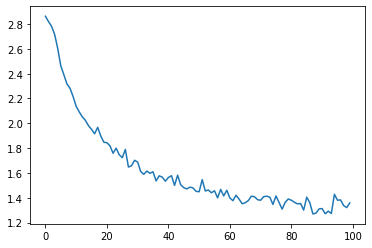

In [13]:
current_loss = 0
all_losses_list = [] #为了后面画图用
plot_steps, print_steps = 1000, 5000
n_iters = 100000 #10000 个 epoch?

for i in range(n_iters):
    # category_lines is a category to name list map
    category, name, category_tensor, name_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train_helper(name_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses_list.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {name} / {guess} {correct}")
        
    
plt.figure()
plt.plot(all_losses_list)
plt.show()

In [14]:
# Model Evaluation (自己写的，试一下..)

total = 1000
n_correct = 0
for i in range(total):
    with torch.no_grad():
        category, name, category_tensor, name_tensor = random_training_example_with_split(category_lines, all_categories, True)

        hidden = rnn.init_hidden()
    
        for i in range(name_tensor.size()[0]):
            output, hidden = rnn(name_tensor[i], hidden)

        guess = category_from_output(output[0])
        
#         print(f'name {name} guess {guess}, category {category}')
        if(category == guess):
            n_correct+=1
            

print(f'Accuracy {100 * n_correct / total}')
        

Accuracy 57.9


In [33]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [35]:
predict("Ashley")


> Ashley
English


----------------------
----------------------

### PyTorch Tutorial - RNN & LSTM & GRU - Recurrent Neural Nets

https://www.youtube.com/watch?v=0_PgWWmauHk&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=20

他这里很骚的非得 RNN 来做 image classification: We treat one image dim as sequence and the other as dimensions

In [42]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 784 # 28x28
num_classes = 10 # 10 个数字 0->9
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# We treat one image dim as sequence and the other as dimensions
# 因为 picture 是 28x28
input_size = 28 
sequence_length = 28

hidden_size = 128
# RNN 的 layer 不懂啥意思。。 可能就是两层 hidden layer
#  input -> hidden1 (self loop) -> hidden2 (self loop) -> output (linear+softmax)
# "setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with
# the second RNN taking in outputs of the first RNN and computing the final results"
num_layers = 2 


In [ ]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)



In [54]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # batch_first=True means  input and output tensors are 
        # provided as (batch, seq, feature) instead of (seq, batch, feature).
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        # Question： 为啥 hidden0 是这个 shape?? 2 x ? x 128  x.size(0) 是 batch size? 100?? what??
        # Answer: 
        #  h0 是 initialized hidden state, 0 这里表示是 time (initial) 而不是第0 层
        #  根据官方文档, hidden laysers initial state 就是
        #   （D * number_layers, batch_size, hidden_size)
        #     D=2 if bidirectional=True otherwise 1
        # ref: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html 
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        #我的 input 长这样： x: (n, 28, 28), h0: (2, n, 128)，  n 这里是 batch_size 即一次多少个 training sample
        
        # Output: 即 每个 h_t (t from 0-> seq_len) 都给你, 所以是 (batch_size, seq_len, hidden_size) ， 
        #    这里 t 的长度，对应的是 seq_len, 那么在我们这个例子里，就是 28 , 因为我们把图的一个 dim 作为 seq_len, 另一个 dim 作为 input_size
        # H_n: 即 给你 每个 batch 的最后一个 t 的 hidden state (比如两层 RNN 就两个 hidden state 都给你） ，
        #    所以 dim 是 (num_layers, batch_size, output_size)
        # 所以其实最后算 output 两个方法都可以
        out, h_n = self.rnn(x, h0)
        
        
        # Question: 这里为啥不能用 h_n? Answer: 试了一下就是可以
        # h_n: (2, n, 128) but we want n, 128
        # 拿最终 h_t 的 output 的写法1
        # output shape: (num_layers, batch_size, output_size)
        out = h_n[-1, :, :]
        
        
        # Decode the hidden state of the last time step
        # 拿最终 h_t 的 output 的写法2:
        # tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        # out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out
        
        
        
        
        
        

In [55]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
# Training loop 跟之前 CNN 是一样
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        # Question: 诶？？这边 reshape 跟之前还不太一样...  之前是 images = images.reshape(-1, 28*28).to(device)
        # Answer: 哦，因为我之前是 CNN 的例子，这里是 RNN, 而且我 input 期待的就是 x: (n, 28, 28), batch_size x seq_len x input_feature_len 这么用
        # 然后这里 -1 是一个 reshape 的默认计算，而不是指倒数第一个
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/2], Step [100/600], Loss: 1.0107
Epoch [1/2], Step [200/600], Loss: 0.7195
Epoch [1/2], Step [300/600], Loss: 0.3752
Epoch [1/2], Step [400/600], Loss: 0.4237
Epoch [1/2], Step [500/600], Loss: 0.2348
Epoch [1/2], Step [600/600], Loss: 0.2227
Epoch [2/2], Step [100/600], Loss: 0.3031
Epoch [2/2], Step [200/600], Loss: 0.1686
Epoch [2/2], Step [300/600], Loss: 0.1467
Epoch [2/2], Step [400/600], Loss: 0.1627
Epoch [2/2], Step [500/600], Loss: 0.2621
Epoch [2/2], Step [600/600], Loss: 0.1903


In [56]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 93.83 %
